In [206]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os


In [207]:
#dataset
class BMIDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self,idx
                    ):
        img_path = self.annotations.iloc[idx, 5]
        image = Image.open(img_path).convert("RGB")
        bmi_label = float(self.annotations.iloc[idx, 4])

        if self.transform:
            image = self.transform(image)

        return (image, bmi_label)
    

In [208]:
resize = 224

In [209]:
transform = transforms.Compose([
    transforms.Resize((resize, resize)),  # Chọn kích thước ảnh sau khi augment
    transforms.ToTensor(),  # Chuyển ảnh sang tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Chuẩn hóa tensor
])

In [210]:
transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [211]:
class BMIModel(nn.Module):
    def __init__(self, shape_data=[3,resize], num_filters =[6,10], kernel_size=[3,3], maxpooling=[2,2]):
        super().__init__()
        self.shape_data = shape_data
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.maxpooling = maxpooling
        
        
        # input -> conv2d -> batchnorm -> maxpool2d ->conv2d -> batchnorm -> maxpool 
        
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

        self.conv1 = nn.Conv2d(
                            in_channels=self.shape_data[0], 
                            out_channels=self.num_filters[0], 
                            kernel_size=self.kernel_size[0],
                            )

        self.conv2 = nn.Conv2d(
                            in_channels=self.num_filters[0], 
                            out_channels=self.num_filters[1], 
                            kernel_size=self.kernel_size[1],
                            )
        # self.conv3 = nn.Conv2d(
        #                     in_channels=self.num_filters[1], 
        #                     out_channels=1, 
        #                     kernel_size=3,
        #                     )
        # nn.init.xavier_uniform_(self.conv1.weight)
        # nn.init.zeros_(self.conv1.bias)
        # nn.init.xavier_uniform_(self.conv2.weight)
        # nn.init.zeros_(self.conv2.bias)

        self.f_activation1 = nn.ReLU()
        self.f_activation2 = nn.ReLU()


        # torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)
        self.batchNorm1 = nn.BatchNorm2d(num_features=self.num_filters[0])
        self.batchNorm2 = nn.BatchNorm2d(num_features=self.num_filters[1])

        # torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        
        self.maxpooling1 = nn.MaxPool2d(kernel_size=self.maxpooling[0])
        self.maxpooling2 = nn.MaxPool2d(kernel_size=self.maxpooling[1])
        
        self.h_conv1 = int((self.shape_data[1] - self.kernel_size[0]) + 1)
        #self.w_conv1 = int((self.shape_data[2] - self.kernel_size[0]) + 1)

        self.h_maxpool1 = int((self.h_conv1 - self.maxpooling[0])/self.maxpooling[0] + 1)
        #self.w_maxpool1 = int((self.w_conv1 - self.maxpooling[0])/self.maxpooling[0] + 1)  

        self.h_conv2 = int((self.h_maxpool1 - self.kernel_size[1]) + 1)
        #self.w_conv2 = int((self.w_maxpool1 - self.kernel_size[1]) + 1)

        self.h_maxpool2= int((self.h_conv2 - self.maxpooling[1])/self.maxpooling[1] + 1)
        #self.w_maxpool2 = int((self.w_conv2 - self.maxpooling[1])/self.maxpooling[1] + 1)  

        # self.h_conv3 = int((self.h_maxpool2 - 3) + 1)
        # self.w_conv3 = int((self.w_maxpool2 - 3) + 1)
        
        
        
        self.linear = nn.Linear(self.h_maxpool2*self.h_maxpool2*num_filters[1], 1)
    def forward(self,x):
        x = self.conv1(x)
        x = self.f_activation1(x)
        x = self.batchNorm1(x)
        x = self.maxpooling1(x)
        
        
        x = self.conv2(x)
        x = self.f_activation2(x)
        x = self.batchNorm2(x)
        x = self.maxpooling2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        
        return x

In [212]:
model = BMIModel()

In [213]:
dataset = BMIDataset(csv_file ='/home/quanhhh/Documents/pre_bmi/pr_databmi.csv',
                     root_dir = '/home/quanhhh/Documents/vip/vip/data/data/',
                     transform = transform )

In [214]:
annotations = pd.read_csv('/home/quanhhh/Documents/pre_bmi/pr_databmi.csv')
img_path = annotations.iloc[ : , 5]
img_path

0       /home/quanhhh/Documents/vip/vip/data/data/f_00...
1       /home/quanhhh/Documents/vip/vip/data/data/f_00...
2       /home/quanhhh/Documents/vip/vip/data/data/f_00...
3       /home/quanhhh/Documents/vip/vip/data/data/f_00...
4       /home/quanhhh/Documents/vip/vip/data/data/f_00...
                              ...                        
1021    /home/quanhhh/Documents/vip/vip/data/data/m_50...
1022    /home/quanhhh/Documents/vip/vip/data/data/m_51...
1023    /home/quanhhh/Documents/vip/vip/data/data/m_51...
1024    /home/quanhhh/Documents/vip/vip/data/data/m_51...
1025    /home/quanhhh/Documents/vip/vip/data/data/m_51...
Name: path, Length: 1026, dtype: object

In [215]:
#set up data loader and transformations
total_samples = len(dataset)
total_samples
from torch.utils.data import random_split
total_samples = len(dataset)
train_size = int(0.7 * total_samples)  # Adjust the split ratio as needed
test_size = total_samples - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])

In [216]:
batch_size = 226


In [217]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size= 308, shuffle=True)



In [218]:
model = BMIModel()


In [219]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [220]:
criterion = RMSELoss()  # Root Mean Squared Error Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [221]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [222]:


#create variable to tracks things
num_epochs = 25

losses = []
y_r = []
y_p = []



n_total_steps = len(train_loader)
#For Loop of epochs
for epoch in range(num_epochs):
   
    
    #train
   
    for i, (image, bmi_labels) in enumerate(train_loader):
        
    
        y_pred = model(image)
        
        y_r.append(bmi_labels)
        y_p.append(y_pred)
        
        
        loss = criterion(y_pred, bmi_labels.view(-1, 1).float())/len(train_loader)
        losses.append(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if(i+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
print("finish training")

Epoch [1/25], Step [1/4], Loss: 5.9234
Epoch [1/25], Step [2/4], Loss: 3.6316
Epoch [1/25], Step [3/4], Loss: 2.2105
Epoch [1/25], Step [4/4], Loss: 2.7778
Epoch [2/25], Step [1/4], Loss: 3.2070
Epoch [2/25], Step [2/4], Loss: 2.6357
Epoch [2/25], Step [3/4], Loss: 2.1507
Epoch [2/25], Step [4/4], Loss: 1.6194
Epoch [3/25], Step [1/4], Loss: 2.1064
Epoch [3/25], Step [2/4], Loss: 2.2944
Epoch [3/25], Step [3/4], Loss: 2.0258
Epoch [3/25], Step [4/4], Loss: 1.5309
Epoch [4/25], Step [1/4], Loss: 1.6885
Epoch [4/25], Step [2/4], Loss: 1.6304
Epoch [4/25], Step [3/4], Loss: 1.6130
Epoch [4/25], Step [4/4], Loss: 1.5560
Epoch [5/25], Step [1/4], Loss: 1.3689
Epoch [5/25], Step [2/4], Loss: 1.3489
Epoch [5/25], Step [3/4], Loss: 1.6567
Epoch [5/25], Step [4/4], Loss: 1.3873
Epoch [6/25], Step [1/4], Loss: 1.1903
Epoch [6/25], Step [2/4], Loss: 1.2162
Epoch [6/25], Step [3/4], Loss: 1.4232
Epoch [6/25], Step [4/4], Loss: 1.8335
Epoch [7/25], Step [1/4], Loss: 1.0582
Epoch [7/25], Step [2/4],

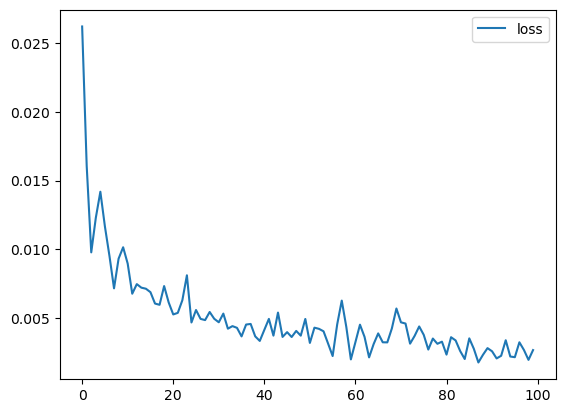

In [223]:
import matplotlib.pyplot as plt
%matplotlib inline
losses = [tl.item() for tl in losses]
plt.plot( [t /226 for t in losses ], label = "loss")

plt.legend()
          

In [224]:
num_epochs = 10

losses = []
y_r = []
y_p = []



n_total_steps = len(train_loader)
#For Loop of epochs
for epoch in range(num_epochs):
   
    
    #train
   
    for i, (image, bmi_labels) in enumerate(train_loader):
        
    
        y_pred = model(image)
        
        y_r.append(bmi_labels)
        y_p.append(y_pred)

In [ ]:
test_loss = 0.0
test_score = 0.0
test_loss_list = []
pred_list = []
truth_list = []
label_list = []
score_list = []


In [ ]:
from sklearn.metrics import mean_absolute_error
losses_ = []
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, bmi_labels in test_loader:
        # Assuming your model takes images as input
        bmi_out = model(images)
        loss_ = criterion(bmi_out, bmi_labels.view(-1, 1).float())/len(train_loader)
        losses_.append(loss)
        bmi_out = pd.DataFrame(bmi_out)
        print(bmi_out)
        bmi_labels = pd.DataFrame(bmi_labels)
        print(bmi_labels)
        
# Compute accuracy
   
    score = mean_absolute_error(bmi_labels, bmi_out)
    print("The Mean Absolute Error of our Model is {}".format(round(score, 2)))

In [ ]:
torch.save(model, 'model.pth')

In [ ]:
model = torch.load('model.pth')

for para in model.parameters():
    print(para)

In [ ]:
def train():
    # train_epoch
    # test_epoch
    # luu model/ tra ve model
    # self.best_model = copy.deepcopy(self.model)
    pass




In [ ]:
with torch.no_grad():
    image = Image.open('a.jpg').convert("RGB")
   
    image = transform(image)
    image = image.unsqueeze_(0)
    #y =image.size()
    y = model(image)

    print(y)